### 1. Load Packages and data

In [2]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm
import wget

from matplotlib.widgets import Slider, Button, RadioButtons
from scipy import interp
from scipy.optimize import fsolve
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold ,train_test_split
from sklearn.metrics import mutual_info_score, roc_auc_score
from datetime import datetime as dt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


from IPython.display import display

In [5]:
data= "https://raw.githubusercontent.com/ColombiaMRP/What-variables-should-be-consider-for-an-online-loan-applicant-/main/Data/Lending_club_cleaned_2.csv"
data= wget.download(data)
df= pd.read_csv(data)

In [6]:
df

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65%,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27%,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96%,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49%,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69%,3000,other,60 months,B
...,...,...,...,...,...,...,...,...,...,...
38700,Fully Paid,110000.0,Not Verified,4 years,MORTGAGE,8.07%,2500,home_improvement,36 months,A
38701,Fully Paid,18000.0,Not Verified,3 years,RENT,10.28%,8500,credit_card,36 months,C
38702,Fully Paid,100000.0,Not Verified,< 1 year,MORTGAGE,8.07%,5000,debt_consolidation,36 months,A
38703,Fully Paid,200000.0,Not Verified,< 1 year,MORTGAGE,7.43%,5000,other,36 months,A


### 2. Data preparation

In [7]:
df.dtypes

loan_status             object
annual_inc             float64
verification_status     object
emp_length              object
home_ownership          object
int_rate                object
loan_amnt                int64
purpose                 object
term                    object
grade                   object
dtype: object

In [5]:
df.int_rate = df.int_rate.str.rstrip('%').astype('float')
df2=df.copy()

In [154]:
df.head(10)

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,1,-0.710290,Verified,10+ years,RENT,10.65,5000,credit_card,36 months,B
1,0,-0.616866,Source Verified,< 1 year,RENT,15.27,2500,car,60 months,C
2,1,-0.893213,Not Verified,10+ years,RENT,15.96,2400,small_business,36 months,C
3,1,-0.317912,Source Verified,10+ years,RENT,13.49,10000,other,36 months,C
4,1,0.161661,Source Verified,1 year,RENT,12.69,3000,other,60 months,B
5,1,-0.523443,Source Verified,3 years,RENT,7.90,5000,wedding,36 months,A
6,1,-0.352105,Not Verified,8 years,RENT,15.96,7000,debt_consolidation,60 months,C
7,1,-0.336596,Source Verified,9 years,RENT,18.64,3000,car,36 months,E
8,0,-0.461161,Source Verified,4 years,OWN,21.28,5600,small_business,60 months,F
9,0,-0.850425,Verified,< 1 year,RENT,12.69,5375,other,60 months,B


#### 2.1 Visual exploration over some variables

<Axes: xlabel='loan_status', ylabel='loan_amnt'>

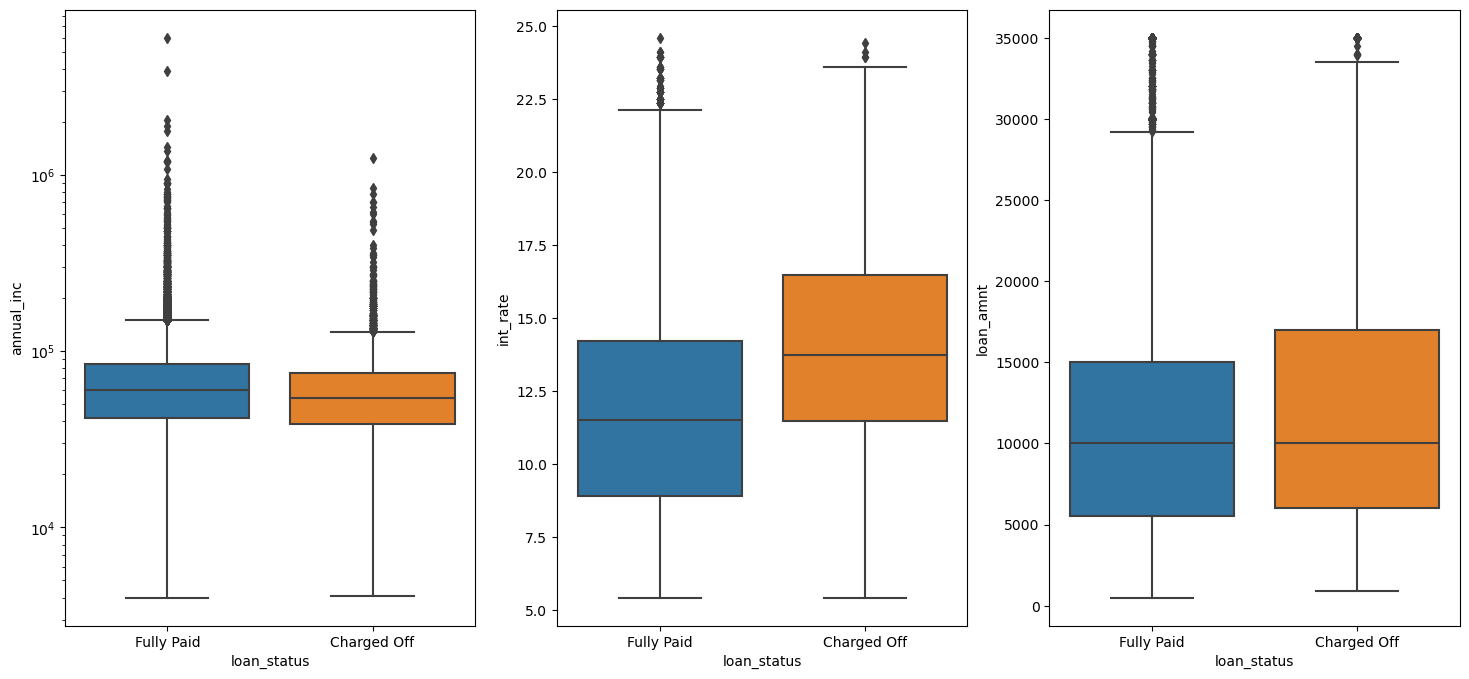

In [6]:
fig, ax=plt.subplots(1,3, figsize=(18,8))
sns.boxplot(y='annual_inc', x='loan_status', data=df, ax=ax[0]).set_yscale('log')
sns.boxplot(y='int_rate', x ='loan_status', data = df, ax=ax[1])
sns.boxplot(y='loan_amnt', x='loan_status', data=df, ax=ax[2])

### 3. EDA

In [6]:
df.isnull().sum()

loan_status            0
annual_inc             0
verification_status    0
emp_length             0
home_ownership         0
int_rate               0
loan_amnt              0
purpose                0
term                   0
grade                  0
dtype: int64

In [12]:
df.loan_status.value_counts(normalize=True)

Fully Paid     0.85945
Charged Off    0.14055
Name: loan_status, dtype: float64

In [17]:
df.purpose.value_counts()

debt_consolidation    18275
credit_card            5007
other                  3838
home_improvement       2887
major_purchase         2116
small_business         1786
car                    1499
wedding                 935
medical                 670
moving                  559
house                   369
vacation                352
educational             317
renewable_energy         95
Name: purpose, dtype: int64

In [17]:
numerical = ["annual_inc","int_rate","loan_amnt"]

In [54]:
categorical = ["purpose","verification_status","emp_length","home_ownership","term","grade"]

In [55]:
df[categorical].nunique()

purpose                14
verification_status     3
emp_length             11
home_ownership          4
term                    2
grade                   7
dtype: int64

In [127]:
df.loan_status = (df.loan_status == 'Fully Paid').astype(int)
df.loan_status.mean()

0.8594496835034233

### 4. Feature importance

#### 4.1 Contengency tables

In [7]:
def get_ct(df, var):
    ct_res = pd.crosstab(df[var], df['loan_status'], margins=True)
    ct_res['Fully Paid(%)'] = round( ct_res['Fully Paid']/ct_res['All']*100, 2)
    return ct_res.drop(columns='All')

In [8]:
get_ct(df, 'verification_status')

loan_status,Charged Off,Fully Paid,Fully Paid(%)
verification_status,,,
Not Verified,2050,14449,87.58
Source Verified,1413,8406,85.61
Verified,1977,10410,84.04
All,5440,33265,85.94


In [9]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(index=df['verification_status'], columns=df['loan_status']))
print('verification_status: p-value of chisquare test =', p)

verification_status: p-value of chisquare test = 6.884998281535999e-17


In [10]:
def get_ct_stra(stra_var):
    ct_stra = pd.crosstab(index=[stra_var,df.verification_status], columns = df.loan_status, margins = True)
    ct_stra['Fully Paid (%)'] = round(ct_stra['Fully Paid']/ct_stra['All']*100,2)
    return ct_stra.drop(columns='All').drop('All', level=0)

In [11]:
get_ct_stra(df.home_ownership)

loan_status                         Charged Off  Fully Paid  Fully Paid (%)
home_ownership verification_status                                         
MORTGAGE       Not Verified                 798        6064           88.37
               Source Verified              487        3443           87.61
               Verified                     983        5480           84.79
OTHER          Not Verified                  10          42           80.77
               Source Verified                1           9           90.00
               Verified                       7          29           80.56
OWN            Not Verified                 170        1210           87.68
               Source Verified              110         622           84.97
               Verified                     122         611           83.36
RENT           Not Verified                1072        7133           86.93
               Source Verified              815        4332           84.17
               Verified                     865        4290           83.22

In [12]:
get_ct_stra(df.term)

loan_status                     Charged Off  Fully Paid  Fully Paid (%)
term       verification_status                                         
 36 months Not Verified                1580       12574           88.84
           Source Verified              688        6132           89.91
           Verified                     805        6505           88.99
 60 months Not Verified                 470        1875           79.96
           Source Verified              725        2274           75.83
           Verified                    1172        3905           76.92

#### 4.2 Diff and Risk ratio

In [57]:
for c in categorical:
    print(c)
    df_group = df.groupby(c).loan_status.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - df.loan_status.mean()
    df_group['risk'] = df_group['mean'] / df.loan_status.mean()
    display(df_group)
    print()
    print()

purpose


,mean,count,diff,risk
purpose,,,,
car,0.896598,1499,0.037148,1.043223
credit_card,0.896944,5007,0.037495,1.043626
debt_consolidation,0.852093,18275,-0.007357,0.991440
educational,0.835962,317,-0.023488,0.972671
home_improvement,0.884655,2887,0.025206,1.029328
house,0.840108,369,-0.019341,0.977496
major_purchase,0.900284,2116,0.040834,1.047512
medical,0.849254,670,-0.010196,0.988137
moving,0.849732,559,-0.009718,0.988693




verification_status


,mean,count,diff,risk
verification_status,,,,
Not Verified,0.875750,16499,0.016300,1.018966
Source Verified,0.856095,9819,-0.003354,0.996097
Verified,0.840397,12387,-0.019052,0.977832




emp_length


,mean,count,diff,risk
emp_length,,,,
1 year,0.858331,3247,-0.001119,0.998698
10+ years,0.848522,8899,-0.010927,0.987286
2 years,0.870050,4394,0.010600,1.012334
3 years,0.863836,4098,0.004386,1.005104
4 years,0.864692,3444,0.005243,1.006100
5 years,0.860274,3285,0.000824,1.000959
6 years,0.861497,2231,0.002047,1.002382
7 years,0.851831,1775,-0.007619,0.991135
8 years,0.861279,1485,0.001830,1.002129




home_ownership


,mean,count,diff,risk
home_ownership,,,,
MORTGAGE,0.868560,17255,0.009110,1.010600
OTHER,0.816327,98,-0.043123,0.949825
OWN,0.858699,2845,-0.000750,0.999127
RENT,0.851300,18507,-0.008150,0.990517




term


,mean,count,diff,risk
term,,,,
36 months,0.891352,28284,0.031902,1.037119
60 months,0.772862,10421,-0.086587,0.899253




grade


,mean,count,diff,risk
grade,,,,
A,0.942439,9694,0.082989,1.096561
B,0.883560,11697,0.024110,1.028053
C,0.836735,7938,-0.022715,0.973570
D,0.789565,5213,-0.069885,0.918686
E,0.747421,2811,-0.112029,0.869650
F,0.693720,1035,-0.165730,0.807167
G,0.684543,317,-0.174907,0.796489


#### 4.3 Mutual Information

In [45]:
def mutual_info_function_score(series):
    return mutual_info_score(series, df.loan_status)

In [58]:
mi = df[categorical].apply(mutual_info_function_score)
mi.sort_values(ascending=False)

grade                  0.018883
term                   0.010557
purpose                0.004447
verification_status    0.000961
home_ownership         0.000304
emp_length             0.000226
dtype: float64

In [59]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(index=df['home_ownership'], columns=df['loan_status']))
print('verification_status: p-value of chisquare test =', p)

verification_status: p-value of chisquare test = 3.094754275730736e-05


In [60]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(index=df['emp_length'], columns=df['loan_status']))
print('verification_status: p-value of chisquare test =', p)

verification_status: p-value of chisquare test = 0.06419956286286362


#### 4.4 Correlation and numerical variables

In [52]:
df[numerical].corrwith(df.loan_status).abs().sort_values(ascending=False)


int_rate      0.200111
loan_amnt     0.053193
annual_inc    0.038905
dtype: float64

In [33]:
for n in numerical:
    max_value = df[n].max()
    min_value = df[n].min()
    print(f"{n} -> Max Value: {max_value}, Min Value: {min_value}")


annual_inc -> Max Value: 6000000.0, Min Value: 4000.0
int_rate -> Max Value: 24.59, Min Value: 5.42
loan_amnt -> Max Value: 35000, Min Value: 500


In [27]:
df[df.int_rate>20].loan_status.mean(), df[df.int_rate<10].loan_status.mean()

(0.6608996539792388, 0.9369423472889499)

In [63]:
df[df.loan_amnt  >25000].loan_status.mean(), df[df.loan_amnt <5000].loan_status.mean()

(0.7971195992485911, 0.8675875540672526)

In [36]:
df[df.annual_inc >1000000].loan_status.mean(), df[df.annual_inc<20000].loan_status.mean()

(0.9285714285714286, 0.796440489432703)

In [64]:
a=df[df['loan_status']==1]['annual_inc']
b=df[df['loan_status']==0]['annual_inc']
T,p=ttest_ind(a,b)
p

1.9075011302588803e-14

### 5. Setting up the validation framework

In [159]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [161]:
len(df_train), len(df_val), len(df_test)

(23223, 7741, 7741)

In [162]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [163]:
y_train = df_train.loan_status.values
y_val = df_val.loan_status.values
y_test = df_test.loan_status.values

del df_train['loan_status']
del df_val['loan_status']
del df_test['loan_status']

In [164]:
df.loan_status=1

### 6. Logistic model

In [165]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [93]:
#Numerical data normalization

for i in numerical:
    df[i] = (df[i] - df[i].mean())/df[i].std()
    df[i] = (df[i] - df[i].mean())/df[i].std()
    df[i] = (df[i] - df[i].mean())/df[i].std()


logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [94]:
y_pred = logistic_model.predict_proba(X_val)[:, 1]

In [95]:
roc_auc_score(y_val, y_pred)

0.686865847104662

In [96]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.686865847104662

#### 6.1 Cross-Validation

In [102]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [97]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [98]:
dv, model = train(df_train, y_train, C=0.001)

In [99]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [100]:
y_pred = predict(df_val, dv, model)

In [103]:

n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.loan_status.values
        y_val = df_val.loan_status.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.682 +- 0.006
C=0.01 0.687 +- 0.007
C=0.1 0.688 +- 0.007
C=0.5 0.688 +- 0.006
C=1 0.688 +- 0.006
C=5 0.688 +- 0.006
C=10 0.688 +- 0.006


In [104]:
dv, model = train(df_full_train, df_full_train.loan_status.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.6891941422853076

### 7. Random Forest

In [105]:
from sklearn.ensemble import RandomForestClassifier

#### 7.1 Hyperparameter tunning : Max Depth

In [167]:

scores = []

for d in [5, 10, 15]:
    for n in range(10, 211, 20):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [168]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

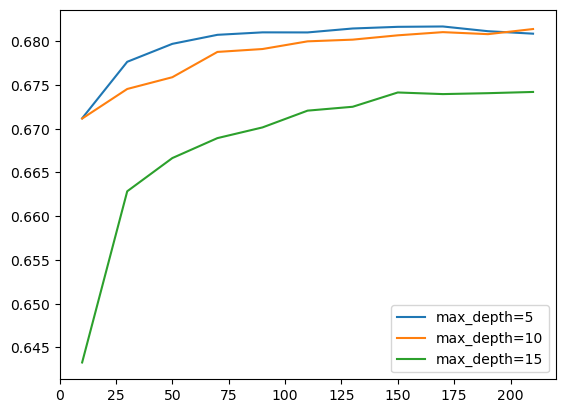

In [169]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

#### 7.1 Hyperparameter tunning : Min Samples Leaf

In [170]:
max_depth = 5
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 211, 20):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [171]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

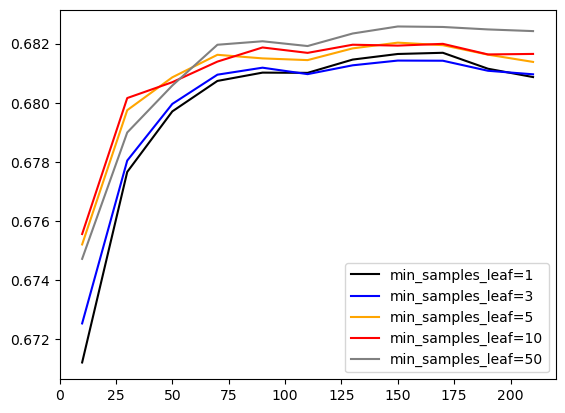

In [172]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [173]:
max_depth = 5
min_samples_leaf = 50
n_estimators= 200

rf = RandomForestClassifier(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=50, n_estimators=200,
                       random_state=1)

In [174]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6825826951498052

### 8. Gradient boosting and XGBoost

In [185]:
import xgboost as xgb
import re

In [188]:
features = dv.get_feature_names_out()
features = [re.sub(r'[\[\]<>]', '', feature) for feature in features]

In [189]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)


In [204]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [206]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.6813715571678087

In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
s = output.stdout
print(s[:200])

In [207]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [209]:
df_score = parse_xgb_output(output)
df_score.head()

,num_iter,train_auc,val_auc
0,0,0.69995,0.66732
1,5,0.73580,0.67833
2,10,0.75513,0.68072
3,15,0.77028,0.67846
4,20,0.78185,0.67838


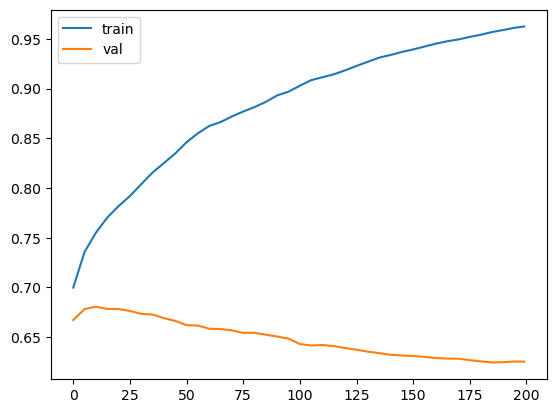

In [213]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

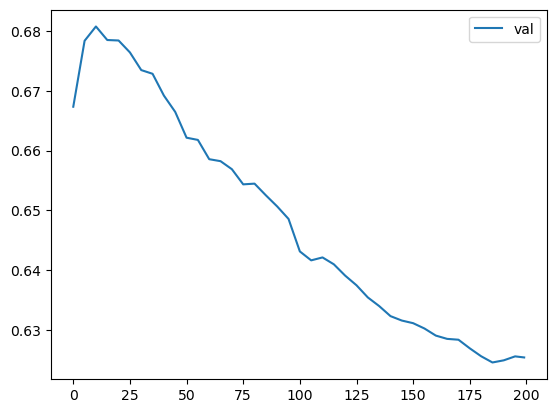

In [214]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

#### 8.1 Hyperparameter tunning : eta

In [222]:

scores = {}

In [231]:
%%capture output

xgb_params = {
    'eta': 0.03, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [232]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.03'

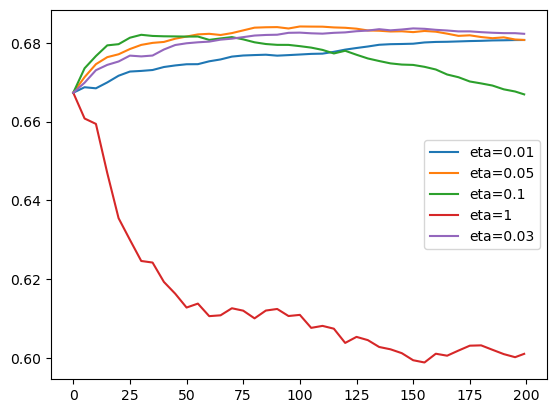

In [235]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()

#### 8.2 Hyperparameter tunning : max_depth

In [236]:

scores = {}

In [243]:
%%capture output

xgb_params = {
    'eta': 0.05, 
    'max_depth': 7,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [244]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=7'

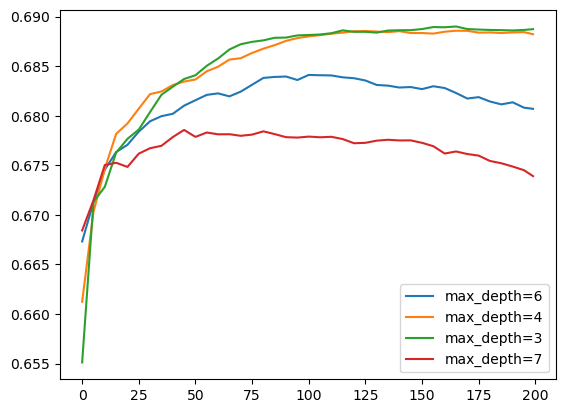

In [245]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.legend()

#### 8.3 Hyperparameter tunning : min_child_weight

In [250]:

scores = {}

In [255]:
%%capture output

xgb_params = {
    'eta': 0.05, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [256]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

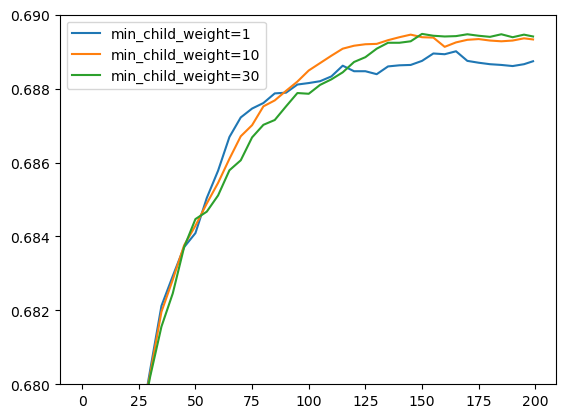

In [258]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.68, 0.69)
plt.legend()

### 9. Model Selection

##### 9.1 Logistic model

In [263]:
dv, model = train(df_full_train, df_full_train.loan_status.values, C=1.0)
y_pred = predict(df_test, dv, model)
roc_auc_score(y_test, y_pred)

0.6891956894151006

##### 9.2 Random Forest

In [262]:
max_depth = 5
min_samples_leaf = 50
n_estimators= 200
rf = RandomForestClassifier(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)

rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6825826951498052

##### 9.3 Xg-Boost

In [260]:
xgb_params = {
    'eta': 0.05, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.6894768910385597

### Save the model

In [266]:
import pickle

In [279]:
ouput_file='model_xgboost.bin'
ouput_file

'model_xgboost.bin'

In [280]:
with open(ouput_file,'wb') as f_out:
    pickle.dump((dv,model),f_out)